In [69]:
%load_ext autoreload
%autoreload 2

%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob
import sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct
from firingrate import raster2FR
from plotting_utils import figSize
from lineplots import plotsd
from session_utils import *
from recalibration_utils import *
from click_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA


files          = glob.glob('D:/T5_ClosedLoop/*')
sessions_check = np.load('misc_data/sessions_check.npy', allow_pickle = True).item()


min_nblocks    = 3       # min number of blocks for a session to be include
max_ndays      = 1e23    # accept all pairs of sessions regardless of time between
min_R2         = 0.1     # subselect days with good decoder performance 

# get click sessions:
sessions       = get_Sessions(files, min_nblocks)                 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
from sklearn.metrics import r2_score
from CosineTuning import angle_between

train_frac = 0.5
task       = None
sigma      = 2
blocks     = None

test_scores    = np.zeros((len(files), 2))
decoding_angle = np.zeros((len(files), 3))

for i, f in enumerate([files[i] for i in range(20)]):
    day        = DataStruct(f, alignScreens = True)

    train_x, test_x, train_y, test_y  = getTrainTest(day, train_frac = train_frac, sigma = sigma, task = task, blocks = blocks, return_flattened = True)
    train_mags, test_mags             = np.linalg.norm(train_y, axis = 1), np.linalg.norm(test_y, axis = 1)

    means       = train_x.mean(axis = 0)
    veldecoder  = LinearRegression(normalize = False).fit(train_x, train_y)
    
    
    magdecoder  = LinearRegression(normalize = False).fit(train_x, train_mags)
    mag_preds   = magdecoder.predict(test_x)
    
    vel_preds   = veldecoder.predict(test_x - means)
    unit_preds  = vel_preds / np.linalg.norm(vel_preds, axis = 1)[:, np.newaxis]
    preds       = unit_preds * mag_preds[:, np.newaxis]
    
    test_scores[i, 0] = scores[0]
    test_scores[i, 1] = r2_score(test_y, preds)
    
    decoding_angle[i, 0] = angle_between(magdecoder.coef_,    veldecoder.coef_[0, :])     # angle between X-velocity decoder and magnitude decoder 
    decoding_angle[i, 1] = angle_between(magdecoder.coef_,    veldecoder.coef_[1, :])     # angle between Y-velocity decoder and magnitude decoder
    decoding_angle[i, 2] = angle_between(veldecoder.coef_[0, :], veldecoder.coef_[1, :])  # angle between X-velocity and Y-velocity decoder 



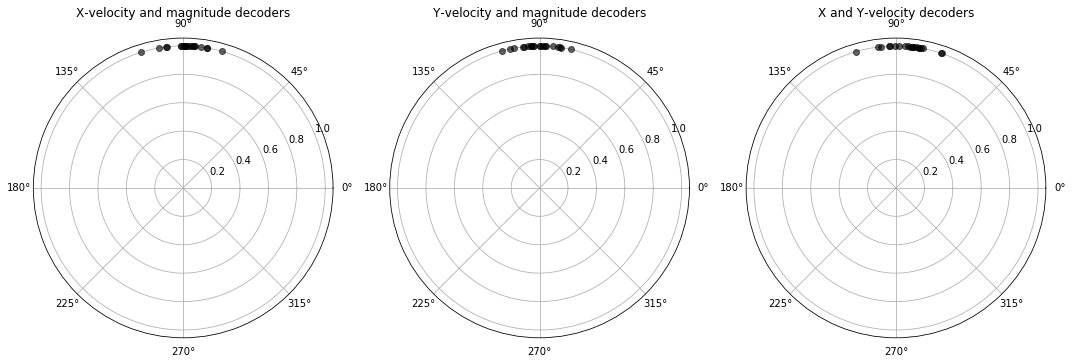

In [129]:
figSize(5, 15)

titles = ['X-velocity and magnitude decoders', 'Y-velocity and magnitude decoders', 'X and Y-velocity decoders']
for i in range(3):
    plt.subplot(1, 3, i + 1, projection = 'polar')
    plt.title(titles[i])
    for j in range(20):
        plt.polar(decoding_angle[j, i], 1, 'ro', color = 'k', alpha = 0.6)
        
plt.tight_layout()

(0, 0.7)

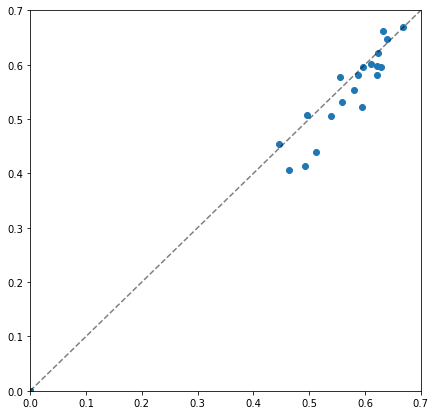

In [95]:
figSize(7, 7)
ax_lims = [0, 0.7]

plt.scatter(test_scores[:, 0], test_scores[:, 1])
plt.plot(ax_lims, ax_lims, color = 'k', linestyle = '--', alpha = 0.5)
plt.xlim(ax_lims)
plt.ylim(ax_lims)

Text(0.5, 1.0, 'Regression predictions on first 40 seconds of cursor activity')

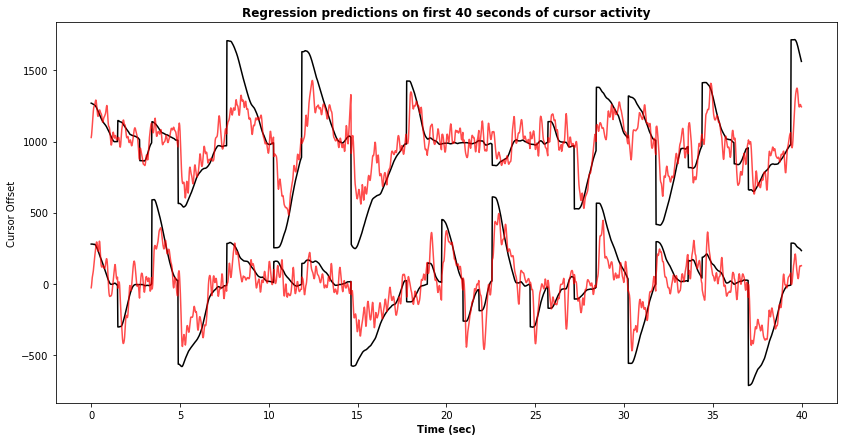

In [96]:
figSize(7, 14)
preds       = decoder.predict(test_x - means)

timelen     = 2000
timestamps  = np.arange(timelen)/ 50 

plt.plot(timestamps, test_y[:timelen, 0], color = 'k')
plt.plot(timestamps, test_y[:timelen, 1] + 1000, color = 'k')

plt.plot(timestamps, preds[:timelen, 0], color = 'r', alpha = 0.7)
plt.plot(timestamps, preds[:timelen, 1] + 1000, color = 'r', alpha = 0.7)

ax = plt.gca()
plt.xlabel('Time (sec)', fontweight = 'bold')
plt.ylabel('Cursor Offset')
plt.title('Regression predictions on first 40 seconds of cursor activity', fontweight = 'bold')

In [222]:
from copy import deepcopy

date   = list()
scores = np.zeros((4, 10)) # rows are 0 - no recalibration; 1- z-score recalibration; 2 - regression recalibration; 3 - full recalibration


for i in range(3, 13):
    file = files[i]
    dat  = DataStruct(file)
    date.append(file.split('t5.')[1].split('.mat')[0])
    
    n_chans    = dat.TX_continuous.shape[1]
    timepoints = dat.TX_continuous.shape[0] - window
    targs      = (dat.targetPos_continuous - dat.cursorPos_continuous)[:(-1 * window), :]
    features   = rolling_window(dat.TX_continuous, window = 5).mean(axis = 2)[:(-1 * window), :]
    
    train_x, test_x = features[:int(timepoints/2), :], features[int(timepoints/2):, :]
    train_y, test_y = targs[:int(timepoints/2), :], targs[int(timepoints/2):, :]
    
    # no recalibration
    scores[0, i-3] = decoder.score(test_x, test_y)
    
    # Mean recalibration:
    lr_NormRecal                 = deepcopy(decoder)
    lr_NormRecal['scaler'].mean_ = train_x.mean(axis = 0)
    #lr_NormRecal['scaler'].scale_ = train_x.std(axis = 0)
    scores[1, i-3]               = lr_NormRecal.score(test_x, test_y)
    
    # Coefficients recalibration:
    normed_features =  decoder['scaler'].transform(train_x)
    lr_TuningRecal  =  LinearRegression().fit(normed_features, train_y)
    scores[2, i-3]  = lr_TuningRecal.score(decoder['scaler'].transform(test_x), test_y)
    
    # Full recalibration:
    lr_FullRecal = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])  
    lr_FullRecal.fit(train_x, train_y)
    scores[3, i-3] = lr_FullRecal.score(test_x, test_y)
    
    
    

In [81]:
decoder['regressor'].intercept_

array([2.60016985, 8.59484223])